# Experiment 1: Not sure what to call this (False Goal Test?)
The different ToM models may struggle with learning which goals are relevant to which agents. For example, an agent wants to go to point B. The path the agent takes will go by point A, but historically, this agent does not visit point A. How well do models learn goal relevance for agents?  

We can test this by designing specific paths for the agents. We will choose the highest probability goal for each agent and the lowest probability goal. Then, we will for the agent to start from a position before the low probability goal such that this goal has to be passed on the way to the true goal. As the agent approaches the false goal, are the models fooled with high certainty that this is the correct goal driving the agent?  

Steps:
1. Load agents and data from experiment 0
2. Choose the starting and goal nodes for each agent
3. Run an experiment for each agent (100) using the models trained on experiment 0 data.
4. Visualize the performance

In [2]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import json

In [3]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [4]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.agents.agent_species import ShortestPathAgent
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color

In [5]:
def visualize_map(campus,
                  path=None,
                  max_goal=None,
                  min_goal=None, 
                  start_goal=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if max_goal:
        goal_coords = [campus.node_coords[max_goal]]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Max Goal")

    if min_goal:
        goal_coords = [campus.node_coords[min_goal]]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="red",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Min Goal")

    if start_goal:
        goal_coords = [campus.node_coords[start_goal]]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="lightgreen",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Start Node")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

## Step 1: Loading Data

In [6]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Started new simulation run #3
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_3_20250515_130420
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges


In [7]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [8]:
import pickle
# if you used dill, just replace pickle with dill

with open('agents.pkl', 'rb') as f:
    agents = pickle.load(f)

In [9]:
with open("./data/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/goal_data.json", 'r') as file:
    goal_data = json.load(file)

In [10]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [11]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 2: Choosing Start and Goal

In [12]:
from tqdm import tqdm

In [13]:
to_remove = []
for agent in tqdm(agents, desc="Processing agents"):
    max_goal_idx = np.argmax(agent.goal_distribution)
    max_goal = goals[max_goal_idx]
    
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]

    G = campus.G_undirected  # your undirected NetworkX graph

    candidates = []
    for s in G.nodes():
        if s in (min_goal, max_goal):
            continue  # optional: don’t start right on one of the goals
        try:
            path = nx.shortest_path(G, s, max_goal, weight="length")
        except nx.NetworkXNoPath:
            continue
        if min_goal in path:
            candidates.append(s)
    
    if not candidates:
        print("No start node forces a pass by min_goal on the way to max_goal")
        to_remove.append(agent)
        continue

    agent.goal_node = max_goal
    agent.start_node = random.choice(candidates)
    agent.current_node = agent.start_node
    agent.plan_path()

    if min_goal not in agent.path:
        print("Problem, missing min goal in path")

Processing agents:   8%|██████▋                                                                            | 8/100 [00:33<07:09,  4.67s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  15%|████████████▎                                                                     | 15/100 [01:01<06:08,  4.33s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  72%|███████████████████████████████████████████████████████████                       | 72/100 [05:23<02:07,  4.55s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [07:20<00:04,  4.35s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [07:24<00:00,  4.44s/it]


In [14]:
agents = [agent for agent in agents if agent not in to_remove]

In [15]:
# Get each agent's path 
for agent in agents:
    agent.plan_path()

## Step 3: Run the Models

### BToM

In [16]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [17]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done


In [18]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

In [19]:
for agent in agents:
    posteriors_data[agent.id] = btom.update_agent_posterior_over_path(agent, agent.path)
# Reset the posteriors for new episode
btom.reset_posteriors()

### Extended BToM

In [20]:
from real_world_src.models.extended_btom import Extended_BToM

In [21]:
with open('extended_btom.pkl', 'rb') as f:
    ext_btom = pickle.load(f)

In [22]:
# Calculate all the posteriors using the first 30 episode
ext_posteriors_data = {}

for agent in agents:
    ext_posteriors_data[agent.id] = ext_btom.update_agent_posterior_over_path(agent, agent.path)


### ToMNet

In [34]:
import torch
from real_world_src.models.simple_tomnet import ToMNet, ToMNetDataset, tomnet_collate_fn, infer_goal_dists, make_support_tensor
from torch.utils.data import Dataset, DataLoader

In [26]:
device = 'mps'

# the values you trained with:
K     = 10
T_sup = 75
T_q   = 20


model = ToMNet(
    num_nodes = len(campus.nodes),
    num_goals = len(goals),
    K     = K,
    T_sup = T_sup,
    T_q   = T_q,
).to(device)

state_dict = torch.load(
    "../real_world_src/models/model_runs/tomnet_cpu.pth",
    map_location=device
)
model.load_state_dict(state_dict)
model.eval()

ToMNet(
  (char_net): CharacterNet(
    (embedding): Embedding(3108, 16, padding_idx=0)
    (lstm): LSTM(16, 64, batch_first=True)
  )
  (mental_net): MentalNet(
    (embedding): Embedding(3108, 16, padding_idx=0)
    (lstm): LSTM(16, 64, batch_first=True)
  )
  (embedding): Embedding(3108, 16, padding_idx=0)
  (fusion): Sequential(
    (0): Linear(in_features=144, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (goal_head): Linear(in_features=64, out_features=15, bias=True)
  (next_head): Linear(in_features=64, out_features=3108, bias=True)
)

In [27]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

In [28]:
train_agent_ids = list(range(0, 70))
test_agent_ids = list(range(70, 100))

In [ ]:


all_episodes    = list(path_data.keys())
examples_train  = []
examples_test   = []

for agent in agents:
    a_id = agent.id

    # choose which list to append into
    if a_id in train_agent_ids:
        continue
    elif a_id in test_agent_ids:
        target = examples_test
    else:
        # silently skip any id outside 0–99
        continue

    for ep in all_episodes:
        # ——— 1) build the K‐shot “support set” for this (agent, ep) ———
        other_eps   = [e for e in all_episodes if e != ep]
        support_eps = random.sample(other_eps, K)

        sup_tensor = torch.zeros(K, T_sup, dtype=torch.long)
        for k, se in enumerate(support_eps):
            raw_sup  = path_data[se][a_id]           # e.g. [n0, n1, n2, …]
            idxs_sup = [node2idx[n] for n in raw_sup]
            L        = min(len(idxs_sup), T_sup)
            sup_tensor[k, :L] = torch.tensor(idxs_sup[:L], dtype=torch.long)

        # ——— 2) unroll *this* episode’s path into (prefix→next) queries ———
        raw_q        = path_data[ep][a_id]
        idxs_q       = [node2idx[n] for n in raw_q]
        true_goal_idx = goal2idx[ goal_data[ep][a_id] ]

        for t in range(1, len(idxs_q)):
            prefix_idxs = idxs_q[:t]     # length t (we’ll pad later)
            next_idx    = idxs_q[t]      # ground‐truth “next node”

            target.append((
                sup_tensor.clone(),      # [K×T_sup] LongTensor
                prefix_idxs,             # Python list of length t
                next_idx,                # int
                true_goal_idx            # int
            ))

print(f"# train examples: {len(examples_train)}")
print(f"# test  examples: {len(examples_test)}")

In [30]:
def get_posterior_format(dists):
    idx2goal = { idx: goal for goal, idx in goal2idx.items() }
    goal_posterior = [ {idx2goal[i]: float(p) for i, p in enumerate(prob_row) } for prob_row in dists]
    return goal_posterior

In [41]:
tomnet_posteriors = {}
episode=0

for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    dists = infer_single_path_goal_dist(model, agent.id, episode, agent.path, path_data, node2idx, goal2idx, K=10, T_sup=75, T_q=20, device=device)
    tomnet_posteriors[agent.id] = get_posterior_format(dists)

In [37]:
import torch.nn.functional as F


In [38]:
def infer_single_path_goal_dist(
    model, agent_id, test_ep, agent_path,
    path_data, node2idx, goal2idx,
    K, T_sup, T_q,
    device='cuda'
):
    model.eval()
    # 1) build support once
    sup     = make_support_tensor(agent_id, test_ep, path_data, node2idx, K, T_sup)
    sup     = sup.to(device).unsqueeze(0)     # add batch‐dim → [1,K,T_sup]

    raw_seq = agent_path
    idxs    = [node2idx[n] for n in raw_seq]
    N       = len(idxs)

    goal_dists = []   # will be list of length N each [num_goals]
    with torch.no_grad():
        for t in range(1, N):
            # build prefix up to t (we treat t=0 as “no steps seen”)
            prefix_len = min(t, T_q)
            # pad prefix to T_q
            prefix = torch.zeros(T_q, dtype=torch.long)
            if prefix_len>0:
                prefix[:prefix_len] = torch.tensor(idxs[:prefix_len], dtype=torch.long)
            # move to device and batch‐dim
            prefix     = prefix.to(device).unsqueeze(0)       # [1,T_q]
            prefix_len = torch.tensor([prefix_len], dtype=torch.long, device=device)

            # forward through ToMNet
            _, goal_logits = model(sup, prefix, prefix_len)   # [1, num_goals]
            p_goal = F.softmax(goal_logits, dim=-1)[0]        # remove batch‐dim → [num_goals]

            goal_dists.append(p_goal.cpu().numpy())

    return goal_dists   # shape (N × num_goals) array

## Step 4: Calculate Brier Score  
We will calculate the brier score for each 10% portion of the path (same as before), but only leading up to the false goal. A model that does not learn historical trends will have a higher brier score since it will be more confident in the false goal. 

In [46]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path, fooled_along_path

In [49]:
btom_scores = []
for agent in agents:
    path = agent.path
    btom_scores.append(brier_along_path(path, 
                              agent.goal_node, 
                              posteriors_data[agent.id], 
                              goals))

ext_scores = []
for agent in agents:
    path = agent.path
    ext_scores.append(brier_along_path(path, 
                              agent.goal_node, 
                              ext_posteriors_data[agent.id], 
                              goals))

tomnet_scores = []
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    path = agent.path
    tomnet_scores.append(brier_along_path(path, 
                              agent.goal_node, 
                              tomnet_posteriors[agent.id], 
                              goals))

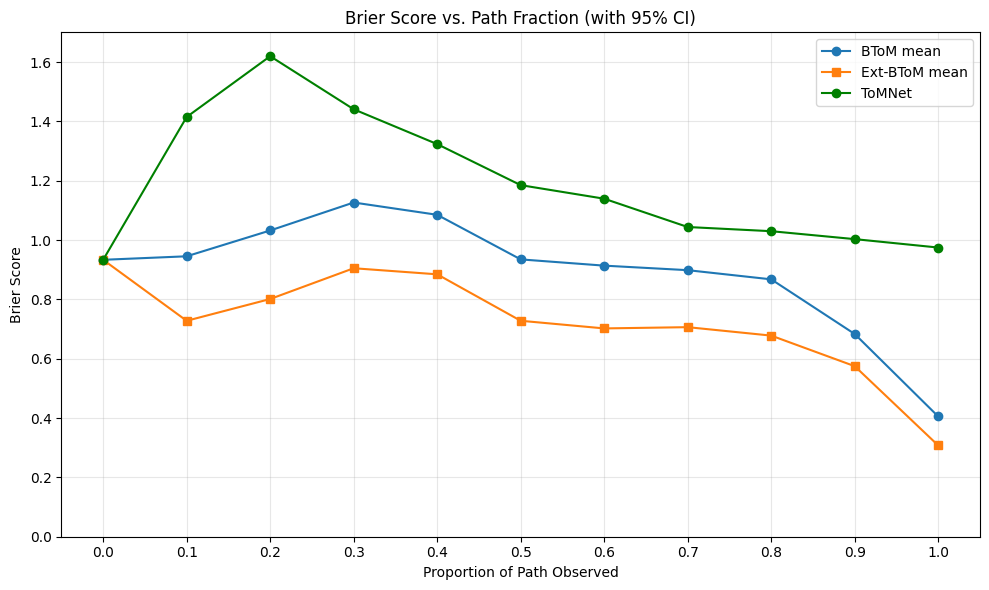

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` and `ext_scores` are your (N × 11) arrays:
arr      = np.array(btom_scores)      # shape (N, 11)
ext_arr  = np.array(ext_scores)  # same shape
tomnet_arr = np.array(tomnet_scores)

props = np.linspace(0, 1, arr.shape[1])


# Compute means 
mean_b = arr.mean(axis=0)
mean_e = ext_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)


plt.figure(figsize=(10,6))

# BToM curve
plt.plot(props, mean_b, '-o', color='C0', label='BToM mean')
# Extended BToM curve
plt.plot(props, mean_e, '-s', color='C1', label='Ext-BToM mean')
# Tomnet curve
plt.plot(props, mean_tomnet, '-o', color='green', label='ToMNet')


plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction (with 95% CI)')
plt.xticks(props)
plt.ylim(0, 1.7)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [57]:
fooled_scores = []
for agent in agents:
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    # Select the path proportion 
    path = agent.path
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    
    fooled_scores.append(fooled_along_path(path, 
                                    agent.goal_node,
                                    min_goal,
                                    posteriors_data[agent.id],
                                    goals))

ext_fooled_scores = []
for agent in agents:
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    # Select the path proportion 
    path = agent.path
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    
    ext_fooled_scores.append(fooled_along_path(path, 
                                    agent.goal_node,
                                    min_goal,
                                    ext_posteriors_data[agent.id],
                                    goals))

tomnet_fooled_scores = []
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    # Select the path proportion 
    path = agent.path
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    
    tomnet_fooled_scores.append(fooled_along_path(path, 
                                    agent.goal_node,
                                    min_goal,
                                    tomnet_posteriors[agent.id],
                                    goals))

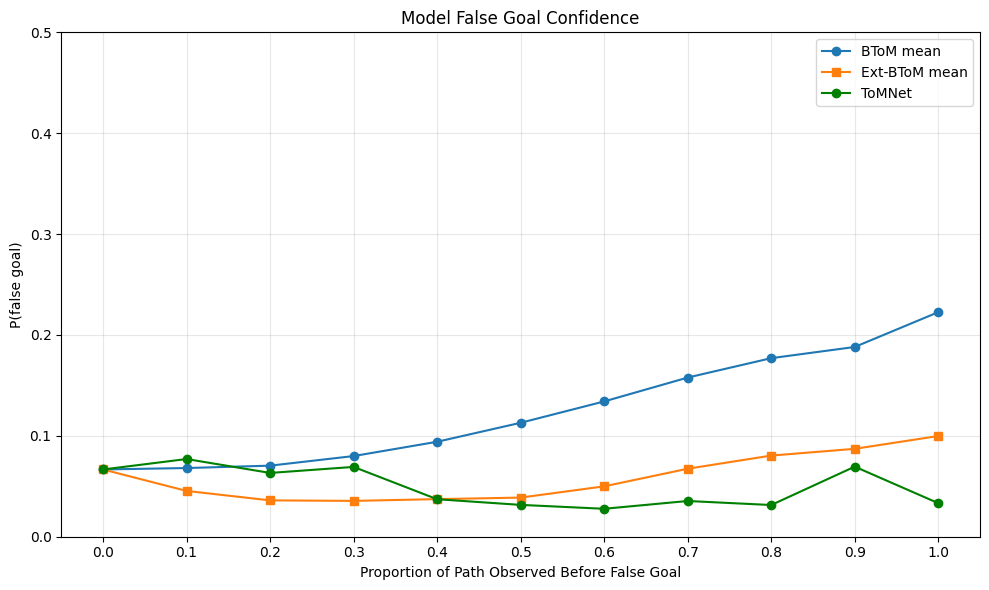

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# your two (n_trajectories × n_fractions) arrays:
arr      = np.array(fooled_scores)      # original BToM
ext_arr  = np.array(ext_fooled_scores)  # extended BToM
tomnet_arr = np.array(tomnet_fooled_scores)

props = np.linspace(0, 1, arr.shape[1])

# --- original BToM stats ---
mean_b = arr.mean(axis=0)

# --- extended BToM stats ---
mean_e = ext_arr.mean(axis=0)

mean_tomnet = tomnet_arr.mean(axis=0)


plt.figure(figsize=(10,6))

# original BToM
plt.plot(props, mean_b, '-o', color='C0', label='BToM mean')

# extended BToM
plt.plot(props, mean_e, '-s', color='C1', label='Ext‐BToM mean')
# Tomnet curve
plt.plot(props, mean_tomnet, '-o', color='green', label='ToMNet')



plt.xlabel('Proportion of Path Observed Before False Goal')
plt.ylabel('P(false goal)')
plt.title('Model False Goal Confidence')
plt.xticks(props)
plt.ylim(0, 0.5)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()